# Introduction

This part of the project focuses on predicting wildfire occurrence in Greece using historical weather, terrain, and fire event data.
Through careful exploratory data analysis (EDA), feature engineering, and model development, we aim to build an interpretable and effective predictive model.

Given the strong class imbalance (few fires relative to non-fires), special attention was paid to balancing recall and precision.
We evaluate both a Logistic Regression baseline and an XGBoost model, leveraging SHAP values to enhance model interpretability and understand the drivers behind wildfire predictions.

# Load Libraries

In [ ]:
# Data handling
import pandas as pd
import numpy as np
import geopandas as gpd

# Geospatial calculations and visualization
from geopy.distance import geodesic
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix, 
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score
)
from sklearn.metrics import ConfusionMatrixDisplay

# Model selection and tuning
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
)

# Explainability
import shap

# Warnings
import warnings

# load files

We load three datasets critical for this project:
- A weather dataset providing is a combination of historical weather, Terrain features and merged with the MODIS dataset. This is done in the "DataMerging" notebook. 
- A MODIS satellite fire dataset containing wildfire detection data.
- A GADM dataset defining regional boundaries for Greece.
https://gadm.org/download_country.html


In [2]:
# Load weather dataset
weather_df = pd.read_csv("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_events_with_weather_with_elevation.csv")
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Load MODIS fire data
modis_path = "/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/fire_archive_M-C61_586436.csv"
modis_df = pd.read_csv(modis_path)
modis_df['acq_date'] = pd.to_datetime(modis_df['acq_date'])

# Load GADM regions
gadm = gpd.read_file("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/gadm41_GRC_1.json")
gadm = gadm.rename(columns={'NAME_1': 'region'})


# EDA

In [64]:
print(f"Weather data shape: {weather_df.shape}")
print(f"MODIS fire data shape: {modis_df.shape}")
print(f"Region boundaries shape: {gadm.shape}")

Weather data shape: (62371, 18)
MODIS fire data shape: (45141, 16)
Region boundaries shape: (8, 12)


## Check imbalancedment

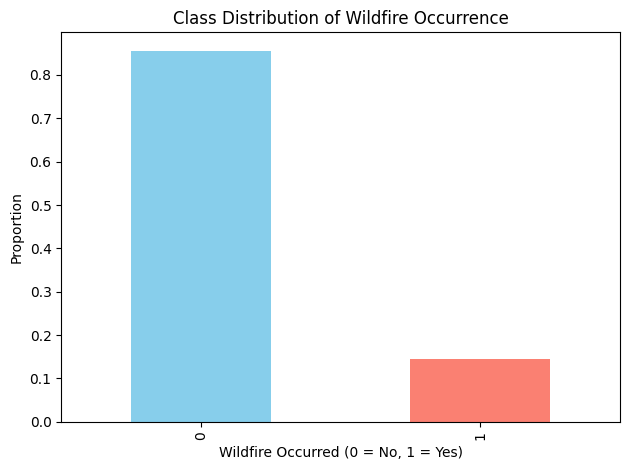

wildfire_occurred
0    85.542961
1    14.457039
Name: proportion, dtype: float64


In [81]:
weather_df['wildfire_occurred'].value_counts(normalize=True).plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    title='Class Distribution of Wildfire Occurrence'
)
plt.xlabel('Wildfire Occurred (0 = No, 1 = Yes)')
plt.ylabel('Proportion')
plt.grid(False)
plt.tight_layout()
plt.show()

# Print exact percentages
print(weather_df['wildfire_occurred'].value_counts(normalize=True) * 100)

The dataset is highly imbalanced, with the majority of days showing no wildfire events.

In [4]:
modis_df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,40.8941,21.4627,307.4,1.1,1.0,2000-11-01,953,Terra,MODIS,60,6.03,288.3,7.5,D,0
1,38.6703,22.5078,312.2,1.2,1.1,2000-11-01,953,Terra,MODIS,72,6.03,297.9,8.2,D,0
2,39.0664,22.4310,308.5,1.2,1.1,2000-11-01,953,Terra,MODIS,66,6.03,294.9,5.7,D,0
3,41.2814,26.2883,303.0,1.2,1.1,2000-11-03,940,Terra,MODIS,51,6.03,292.1,5.5,D,0
4,39.9170,22.5219,302.0,1.0,1.0,2000-11-03,941,Terra,MODIS,47,6.03,290.7,4.1,D,0


In [65]:
modis_df.describe()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,confidence,version,bright_t31,frp,type,year
count,45141.000000,45141.000000,45141.000000,45141.000000,45141.000000,45141,45141.000000,45141.000000,45141.000000,45141.000000,45141.000000,45141.000000,45141.000000
mean,39.239872,23.273897,325.859739,1.560719,1.196943,2012-07-02 17:49:15.459560192,1107.933652,69.586473,11.539625,299.539292,69.117842,0.088500,2011.870960
min,34.943200,19.701000,300.000000,1.000000,1.000000,2000-11-01 00:00:00,0.000000,0.000000,6.030000,267.100000,0.000000,0.000000,2000.000000
25%,38.108400,22.208500,310.200000,1.000000,1.000000,2007-07-26 00:00:00,928.000000,57.000000,6.030000,293.500000,8.500000,0.000000,2007.000000
50%,39.372500,22.775200,318.800000,1.200000,1.100000,2011-08-26 00:00:00,1117.000000,70.000000,6.030000,298.500000,16.800000,0.000000,2011.000000
75%,40.705500,24.080300,331.900000,1.800000,1.300000,2017-11-01 00:00:00,1151.000000,86.000000,6.030000,304.900000,45.000000,0.000000,2017.000000
max,41.749100,28.187600,505.700000,4.800000,2.000000,2024-11-28 00:00:00,2358.000000,100.000000,61.030000,400.100000,6091.700000,3.000000,2024.000000
std,1.586359,1.647505,25.312900,0.763923,0.235994,NaN,453.721158,21.934320,16.513009,9.432632,217.976877,0.432954,6.793174


In [66]:
weather_df.head()

,region,date,temp_avg,temp_max,temp_min,precip,snow_depth,wind_dir,wind_speed,wind_gust,pressure,sunshine_duration,wildfire_count,wildfire_occurred,avg_elevation,max_elevation,min_elevation,year
0,Aegean,2000-01-01,12.325000,14.850000,10.900000,7.1,NaN,309.0,17.333333,NaN,NaN,NaN,0,0,201.19,988.0,0.0,2000
1,Aegean,2000-01-02,10.475000,11.700000,8.800000,0.0,NaN,192.5,16.566667,NaN,NaN,NaN,0,0,201.19,988.0,0.0,2000
2,Aegean,2000-01-03,7.066667,8.733333,4.933333,1.3,NaN,184.5,33.950000,NaN,NaN,NaN,0,0,201.19,988.0,0.0,2000
3,Aegean,2000-01-04,6.350000,7.500000,5.250000,0.0,NaN,330.0,36.200000,NaN,NaN,NaN,0,0,201.19,988.0,0.0,2000
4,Aegean,2000-01-05,6.500000,8.533333,3.466667,0.0,NaN,317.0,21.050000,NaN,NaN,NaN,0,0,201.19,988.0,0.0,2000


In [5]:
weather_df.describe()


,date,temp_avg,temp_max,temp_min,precip,snow_depth,wind_dir,wind_speed,wind_gust,pressure,sunshine_duration,wildfire_count,wildfire_occurred,avg_elevation,max_elevation,min_elevation
count,62919,62912.000000,62622.000000,62539.000000,55554.000000,216.000000,34626.000000,58546.000000,5593.000000,17940.000000,0.0,62919.000000,62919.000000,62919.000000,62919.000000,62919.000000
mean,2012-06-23 14:31:58.695465472,17.489196,22.023286,13.072904,1.667488,59.194444,207.866572,11.659524,27.445532,1015.262126,NaN,0.703126,0.145060,442.615900,1788.371509,-1.683053
min,2000-01-01 00:00:00,-15.600000,-10.000000,-20.600000,0.000000,10.000000,0.000000,0.000000,9.250000,989.000000,NaN,0.000000,0.000000,201.190000,988.000000,-5.000000
25%,2006-04-02 00:00:00,12.200000,16.240000,8.200000,0.000000,10.000000,145.000000,6.825000,18.550000,1011.280000,NaN,0.000000,0.000000,261.163333,1071.000000,-3.000000
50%,2012-05-29 00:00:00,17.225000,21.800000,13.000000,0.000000,10.000000,210.381818,10.000000,24.100000,1014.700000,NaN,0.000000,0.000000,470.780000,1979.000000,-2.000000
75%,2018-11-06 00:00:00,23.600000,28.425000,18.666667,0.116667,20.000000,288.000000,15.200000,34.800000,1018.725000,NaN,0.000000,0.000000,489.623333,2200.000000,0.000000
max,2024-12-31 00:00:00,35.000000,45.400000,32.000000,239.300000,1240.000000,360.000000,58.700000,80.550000,1040.000000,NaN,823.000000,1.000000,841.143333,2205.000000,0.000000
std,NaN,7.087292,7.591433,6.835935,6.036993,191.886229,91.448048,6.672744,10.856730,5.802385,NaN,6.977210,0.352164,188.787615,493.729873,1.723576


## Fires EDA

In [4]:
modis_df['year'] = modis_df['acq_date'].dt.year
fires_per_year = modis_df['year'].value_counts().sort_index()


### Fire events over Time

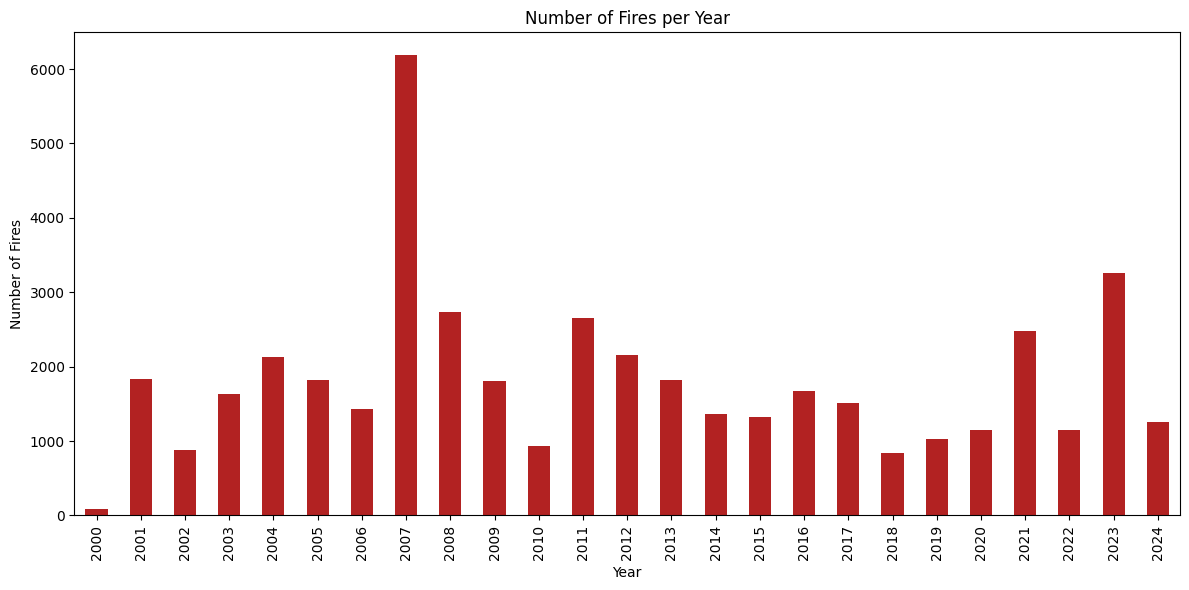

In [5]:
plt.figure(figsize=(12,6))
fires_per_year.plot(kind='bar', color='firebrick')
plt.title('Number of Fires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.grid(False)
plt.show()

We observe a sharp peak in 2007, suggesting an extreme fire season. Recent years - 2021 and 2023, also show increased fire activity. Such trends motivate the need for predictive models that account for changing fire risk patterns over time.

### Fire events by region and Year

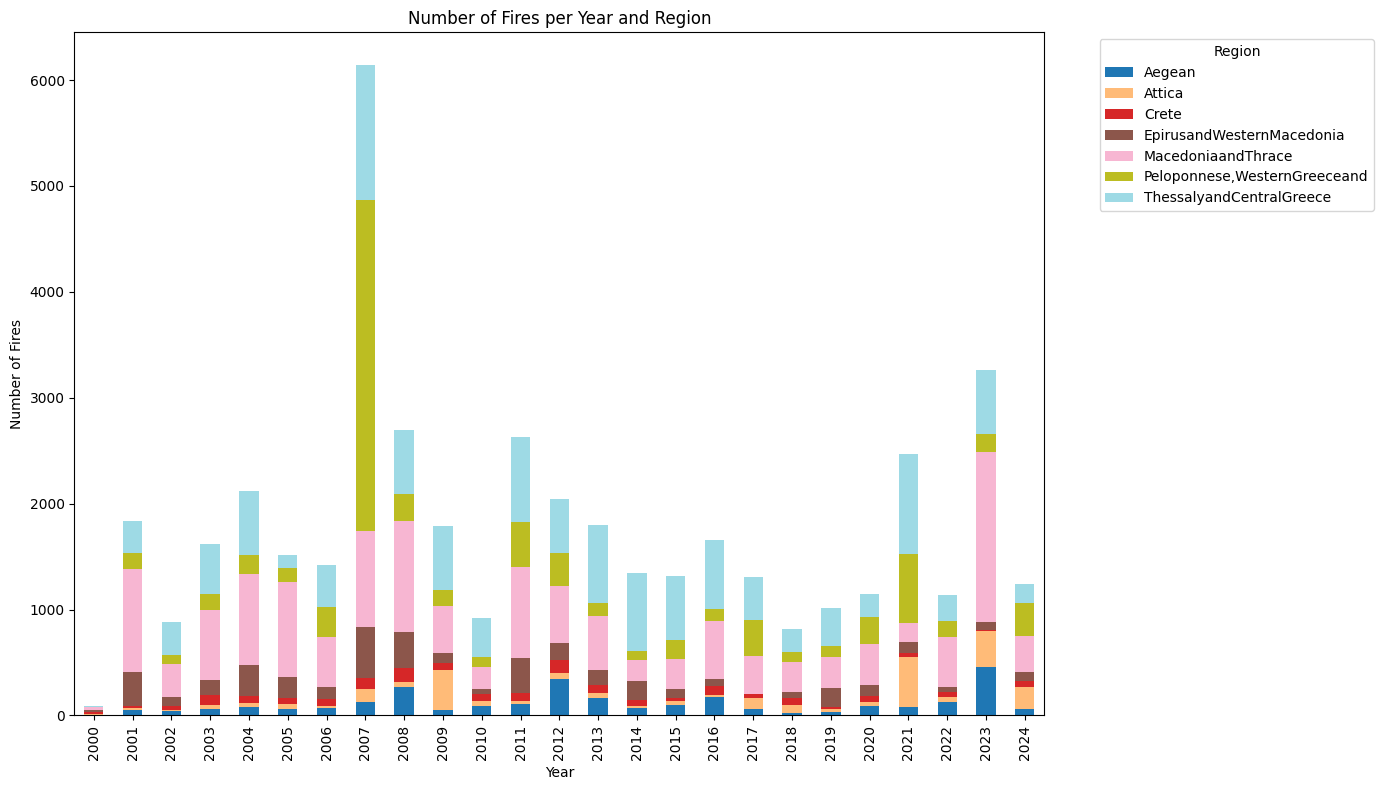

In [ ]:
weather_df['year'] = weather_df['date'].dt.year

fires_year_region = weather_df.groupby(['year', 'region'])['wildfire_count'].sum().unstack(fill_value=0)

# Plot
fires_year_region.plot(
    kind='bar',
    stacked=True,
    figsize=(14,8),
    colormap='tab20'
)

plt.title('Number of Fires per Year and Region')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()

The Peloponnese, Western Greece, Macedonia and Thrace and Thessaly appear to contribute significantly to total fire counts. Peaks are dominated by a few regions, suggesting targeted interventions in high-risk areas could be most effective.

### Fire Detection Confidence Scores


We explore the distribution of fire detection confidence scores to assess the reliability of MODIS fire event observations. To be noted in the "DataMerging" notebook we filter out records that has a confidence score lower that 30%

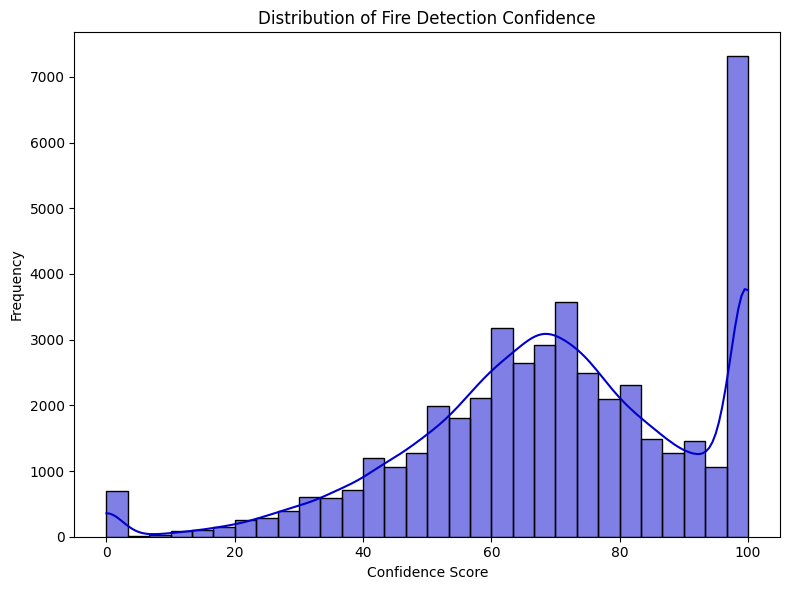

In [68]:
plt.figure(figsize=(8,6))
sns.histplot(modis_df['confidence'], bins=30, kde=True, color='mediumblue')
plt.title('Distribution of Fire Detection Confidence')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.grid(False)
plt.show()

The distribution is skewed toward high confidence scores (70+), suggesting that most detections are reliable. However, there is a long tail at lower confidences, which motivates filtering out low-confidence detections for more robust modeling - Which was done in the "dataMergeing" notebook

## Spatial Distribution of Fires historically

NOTE! made with chatgpt - 4o, prompt: 

“Plot wildfire occurrences on a map of Greece by performing a spatial join between fire points and GADM Level 1 regions. Show Greece outlines and color fire points by region using GeoPandas and Matplotlib. Style the plot professionally: title, no axis, small semi-transparent points, and a region legend."

We map the historical fire events across Greece to visualize spatial clustering and regional fire patterns.

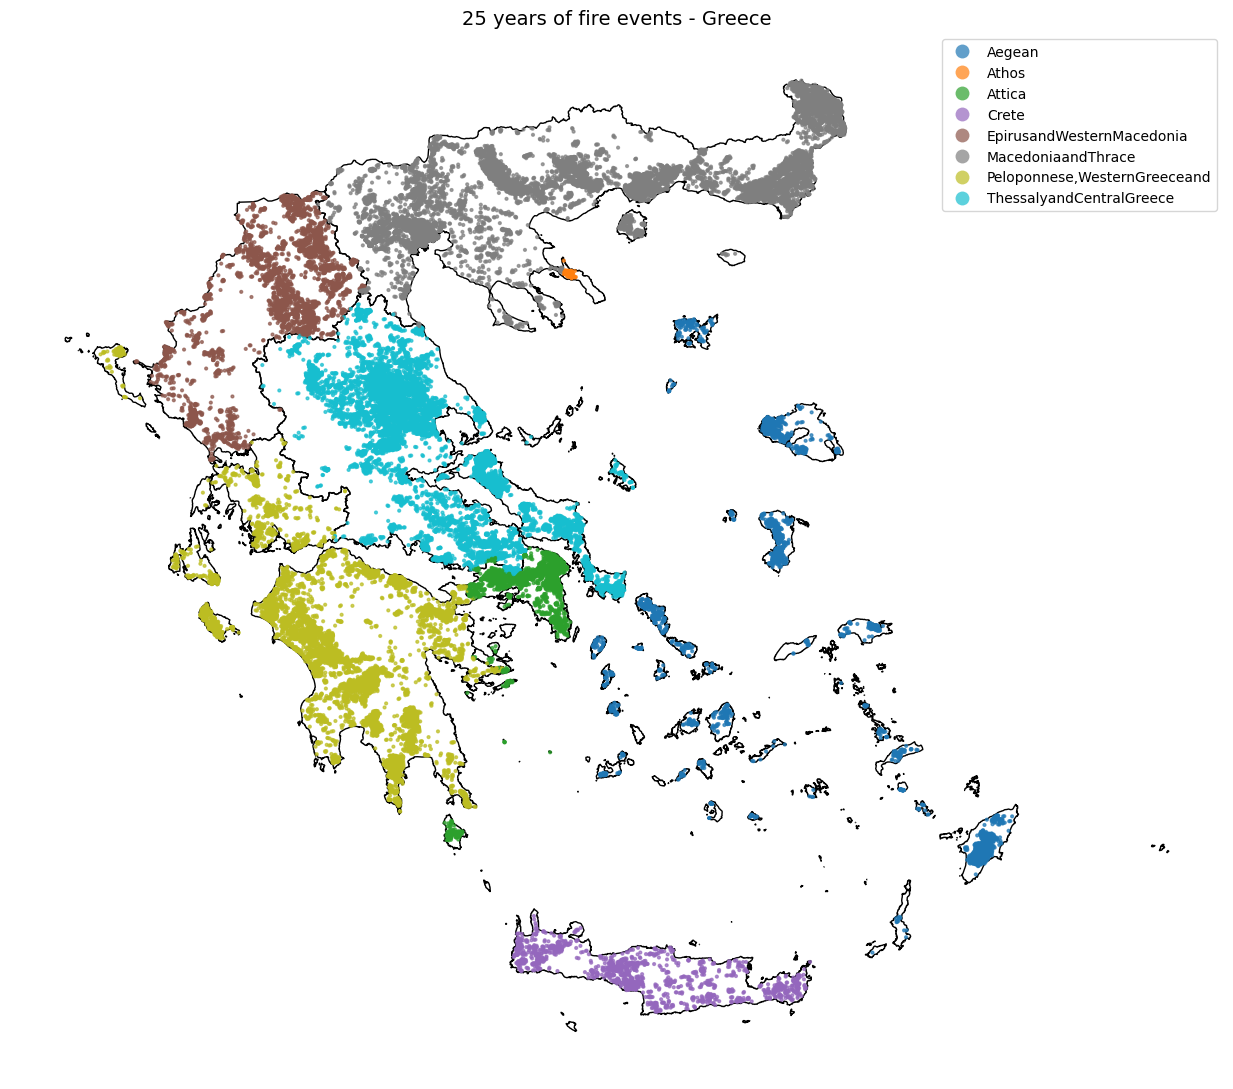

In [9]:
# Load Greece region boundaries (GADM Level 1)
greece_regions = gpd.read_file("/Users/Thomas/Desktop/Skole/Business Analytics/Advanced Business Analytics/Wildfire Prediction/data/raw/gadm41_GRC_1.json")
greece_regions = greece_regions.rename(columns={"NAME_1": "region"})
# --- Spatial join to assign fire region ---
modis_gdf = gpd.GeoDataFrame(
    modis_df,
    geometry=gpd.points_from_xy(modis_df["longitude"], modis_df["latitude"]),
    crs=greece_regions.crs
)

modis_with_region = gpd.sjoin(
    modis_gdf,
    greece_regions[["region", "geometry"]],
    how="inner",
    predicate="intersects"
).drop(columns=["index_right"])

# Optional: rename for plotting aesthetics
modis_with_region = modis_with_region.rename(columns={"region": "region_fire_occurred"})

# --- Plot style ---
fig, ax = plt.subplots(figsize=(13, 11))

# Plot empty outlines of Greece
greece_regions.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)

# Plot MODIS fire dots colored by region
modis_with_region.plot(
    ax=ax,
    column="region_fire_occurred",
    cmap="tab10",
    legend=True,
    markersize=4,
    alpha=0.7
)

# Aesthetics
ax.set_title("25 years of fire events - Greece", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Fire events are densely clustered in mainland Greece and large islands like Crete. Coastal and northern areas appear to experience fewer events. Understanding this spatial distribution supports better regionalized fire risk modeling.

In [69]:
# Just checking max and min values for a fire event in a single day 
weather_df['wildfire_count'].max(), weather_df['wildfire_count'].min()

(np.int64(823), np.int64(0))

## Weather EDA

### Weather Patterns Over Time

We first explore how daily maximum temperatures have evolved from 2000 to 2024 across Greece. This helps identify seasonality, trends, and possible anomalies in climate conditions related to fire risk.

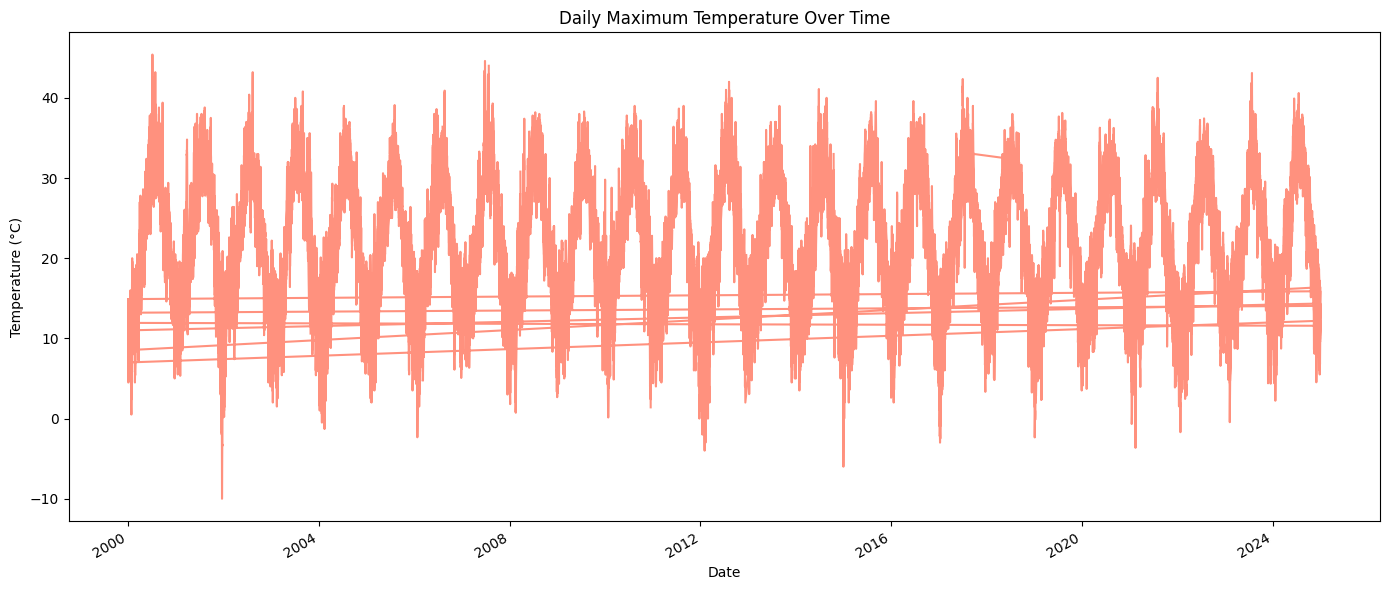

In [11]:
plt.figure(figsize=(14,6))
weather_df.set_index('date')['temp_max'].plot(color='tomato', alpha=0.7)
plt.title('Daily Maximum Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid(False)
plt.tight_layout()
plt.show()

The plot clearly shows strong yearly seasonality, with peak temperatures in summer months. The cyclical nature of temperatures reinforces the importance of using temporal features like month or day-of-year when modeling wildfire occurrence.

### Temperature Histogram

We examine the distribution of daily maximum temperatures to understand typical temperature ranges and identify outliers that may impact fire risk.

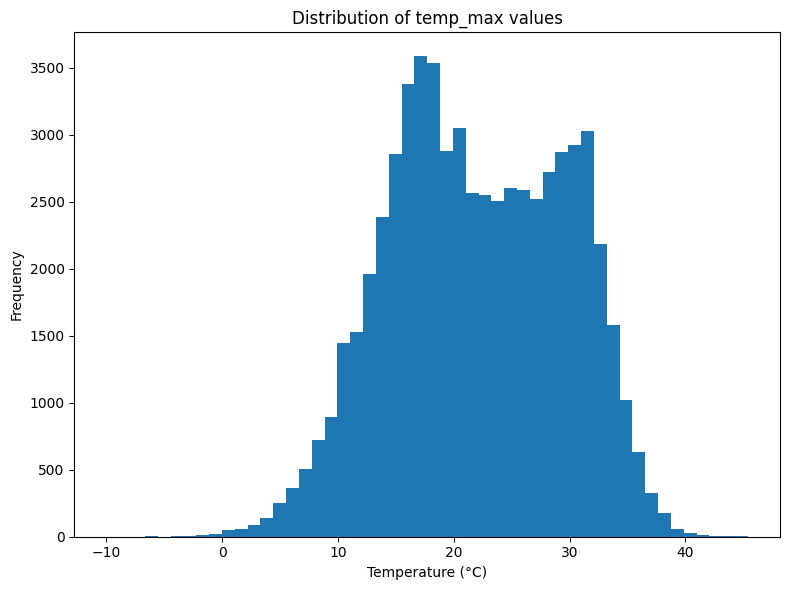

In [71]:
weather_df['temp_max'].hist(bins=50, figsize=(8,6))
plt.title('Distribution of temp_max values')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

The distribution of maximum temperatures is centered around 15–30°C, which aligns with typical Mediterranean climates. A few cold and very hot days are visible at the distribution tails, suggesting occasional extremes that could influence fire ignition and spread.

###  Wind Speed Histogram

Wind plays a critical role in wildfire propagation. We visualize the distribution of daily average wind speeds across the dataset.

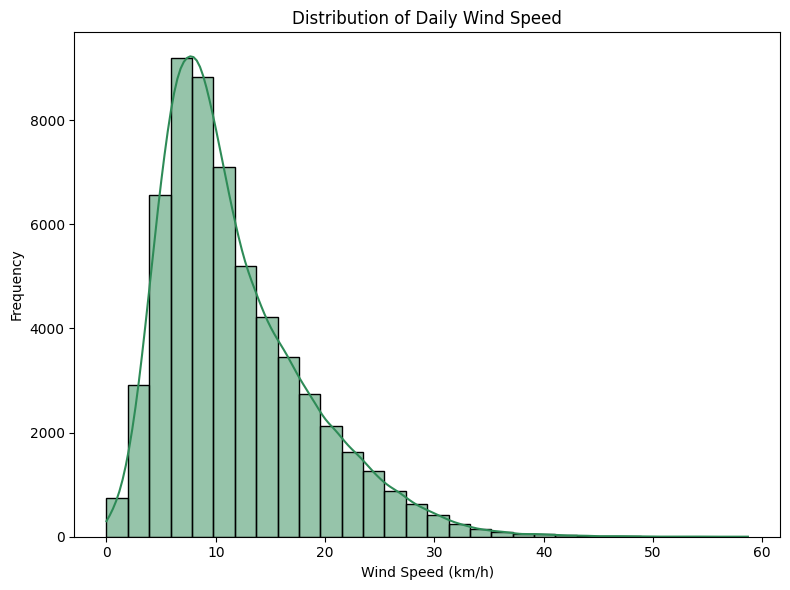

In [62]:
plt.figure(figsize=(8,6))
sns.histplot(weather_df['wind_speed'], bins=30, kde=True, color='seagreen')
plt.title('Distribution of Daily Wind Speed')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.show()

Wind speeds are skewed toward lower values, with most days experiencing mild winds - under 15 km/h. However, there is a heavy tail toward higher wind speeds, which could correspond to conditions that favor rapid wildfire spread.

Understanding seasonality and distribution of meteorological drivers is crucial for building models. In this case, XGBoost, as an ensemble method, benefits from such informative variables to optimize splits and capture complex feature interactions 

## Data cleaning

### Checking Region Distribution


We first examine the number of records per region to ensure a reasonably balanced dataset, which is important for reliable training and evaluation of regional wildfire predictions

In [15]:
weather_df['region'].value_counts()

region
Aegean                          9132
Crete                           9132
Peloponnese,WesternGreeceand    9132
MacedoniaandThrace              9126
Attica                          9117
ThessalyandCentralGreece        8882
EpirusandWesternMacedonia       8398
Name: count, dtype: int64

Most regions have between 8800 and 9100 observations, with only minor imbalance. No immediate action is needed, but regional differences should be kept in mind during evaluation. The difference is because of it was not possible to fetch historical weather on certain dates for those regions

### Missing Value Analysis

We inspect missing values across key weather attributes to decide on appropriate data cleaning strateg

In [16]:
# --- Quick diagnostic for missing values across key weather features ---

important_columns = [
    'temp_avg', 'temp_max', 'temp_min',
    'precip', 'snow_depth', 'wind_dir',
    'wind_speed', 'wind_gust', 'pressure', 'sunshine_duration'
]

# 1. Check missing value count
missing_counts = weather_df[important_columns].isnull().sum()

# 2. Calculate percentage of missing values
missing_percentages = (missing_counts / len(weather_df)) * 100

# 3. Create a clean display DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percentages.round(2)
})

# 4. Show only features with missing values
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

# 5. Display the table
display(missing_summary)

,Missing Count,Missing Percentage
temp_avg,7,0.01
temp_max,297,0.47
temp_min,380,0.60
precip,7365,11.71
snow_depth,62703,99.66
wind_dir,28293,44.97
wind_speed,4373,6.95
wind_gust,57326,91.11
pressure,44979,71.49
sunshine_duration,62919,100.00


Several features like `snow_depth`, `wind_gust`, and `sunshine_duration` have over 90% missing values, indicating they may not be reliable for modeling. Precipitation and wind_speed have moderate missingness and will be imputed accordingly.

Dropping temp_min and temp_max records that dont have any values

### Dropping and Imputing Values

Based on the missing value analysis, we apply the following data cleaning:

- Drop rows with missing `temp_min` or `temp_max` values.
- Impute missing `precip` values with 0 (no rain).
- Impute missing `wind_speed` values with the median wind speed.

In [17]:
# Then drop rows with missing temp_min, temp_max
weather_df = weather_df.dropna(subset=['temp_min', 'temp_max'])

In [19]:
# Impute missing values
# Precipitation: if no measurement, assume 0 mm (no rain)
weather_df.loc[:, 'precip'] = weather_df['precip'].fillna(0)
weather_df.loc[:, 'wind_speed'] = weather_df['wind_speed'].fillna(weather_df['wind_speed'].median())

Handling missing data carefully is critical to ensure robust performance of ensemble models like XGBoost, which can otherwise be sensitive to poor-quality input

# Feature engineering 

We start by copying the cleaned weather dataset to a new `df_features` DataFrame.  
This ensures that all feature engineering steps are isolated and we protect the original data

In [20]:
df_features = weather_df.copy()

In [21]:
df_features['date'] = pd.to_datetime(df_features['date'])

In [71]:
df_features.shape

(62371, 36)

## Dropping columns

We remove the following columns:
- `snow_depth`, `sunshine_duration`, `wind_gust`, and `pressure` (too many missing values)
- `temp_avg` (redundant with temp_min and temp_max)
- `wind_dir` (high missingness, limited value for predictive modeling)

Removing these columns was based on the findings from earlier where we saw the amount of missing values

In [23]:
cols_to_drop = [
    'snow_depth', 
    'wind_gust', 
    'sunshine_duration', 
    'pressure',     
    'temp_avg',
    'wind_dir',      
]

df_features = df_features.drop(columns=cols_to_drop, errors='ignore')

## Terrain features

New terrain-related features are created by combining elevation, temperature, and wind characteristics.  
These features help the model capture how geographic and environmental factors influence wildfire risks.

In [25]:
# Elevation-temperature interaction
df_features['elevation_temp_interaction'] = df_features['avg_elevation'] * df_features['temp_max']

# Elevation range
df_features['elevation_range'] = df_features['max_elevation'] - df_features['min_elevation']

# Rugged terrain + wind effect
df_features['rugged_wind_interaction'] = df_features['elevation_range'] * df_features['wind_speed']

# Temperature range × elevation
df_features['temp_range_elevation'] = (df_features['temp_max'] - df_features['temp_min']) * df_features['avg_elevation']

# Is mountainous region (binary feature)
df_features['is_mountainous'] = (df_features['elevation_range'] > 500).astype(int)


## Temporal features

From the date variable, we extract new features such as month, day of year, and wildfire season indicators.  
These temporal variables allow the model to recognize important seasonal patterns affecting fire activity.

In [ ]:
df_features['month'] = df_features['date'].dt.month
df_features['day_of_year'] = df_features['date'].dt.dayofyear
df_features['weekday'] = df_features['date'].dt.weekday  # Monday=0, Sunday=6
df_features['is_weekend'] = df_features['weekday'].isin([5, 6]).astype(int)
df_features['quarter'] = df_features['date'].dt.quarter

# Wildfire seasonality May to September
df_features['is_wildfire_season'] = df_features['month'].apply(lambda x: 1 if 5 <= x <= 9 else 0)

# Interaction between temperature and month
df_features['temp_month_interaction'] = df_features['temp_max'] * df_features['month']


### Rolling weather - To see trends 

We generate rolling 7-day aggregates for precipitation and temperature to capture short-term weather trends.  
Recent rainfall and heat patterns are critical factors in fire ignition and spread.

In [27]:
# Rolling 7-day total precipitation per region (captures recent rainfall trend)
df_features['precip_7d_sum'] = (
    df_features
    .groupby('region')['precip']
    .transform(lambda x: x.rolling(7, min_periods=1).sum())
)

# Rolling 7-day average max temperature per region (captures recent heat trend)
df_features['temp_max_7d_avg'] = (
    df_features
    .groupby('region')['temp_max']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)


## drought indicator

A drought flag and a custom fire risk index are created based on domain knowledge.  
These summarize the combined effects of heat, wind, and dryness into compact, interpretable variables.

In [28]:
df_features['is_dry'] = (df_features['precip_7d_sum'] < 1.0).astype(int)

# Fire index

In [29]:
df_features['fire_risk_index'] = (
    0.4 * df_features['temp_max'] +
    0.4 * df_features['wind_speed'] -
    0.2 * df_features['precip_7d_sum']
)

## one hot encoding of weekdays

The weekday feature is one-hot encoded to make it suitable for machine learning models to interprate a week day "wedensday" is no numerical value, so that has to be encoded 
This prevents any unintended ordering between weekdays.

In [30]:
df_features = pd.get_dummies(df_features, columns=['weekday'], prefix='wd')

## Wind and temperature indicator

Additional features combining temperature, wind speed, and terrain are created to model complex interactions that influence wildfire behavior.

In [31]:
# Create a new feature based on the interaction of maximum temperature and wind speed
df_features['temp_wind_interaction'] = df_features['temp_max'] * df_features['wind_speed']

### high wind indicator

In [32]:
df_features['is_windy'] = (df_features['wind_speed'] > 30).astype(int)

## Final preperation

Remaining missing values are filled, categorical encodings are cleaned up,  
and the feature set is finalized for model training.  
The dataset is now structured, complete and should be ready

In [33]:
wd_cols = [col for col in df_features.columns if col.startswith('wd_')]
df_features[wd_cols] = df_features[wd_cols].astype(int)

In [34]:
df_features = df_features.fillna(0)

In [35]:
df_features.head()

,region,date,temp_max,temp_min,precip,wind_speed,wildfire_count,wildfire_occurred,avg_elevation,max_elevation,...,fire_risk_index,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,temp_wind_interaction,is_windy
0,Aegean,2000-01-01,14.850000,10.900000,7.1,17.333333,0,0,201.19,988.0,...,11.453333,0,0,0,0,0,1,0,257.400000,0
1,Aegean,2000-01-02,11.700000,8.800000,0.0,16.566667,0,0,201.19,988.0,...,9.886667,0,0,0,0,0,0,1,193.830000,0
2,Aegean,2000-01-03,8.733333,4.933333,1.3,33.950000,0,0,201.19,988.0,...,15.393333,1,0,0,0,0,0,0,296.496667,1
3,Aegean,2000-01-04,7.500000,5.250000,0.0,36.200000,0,0,201.19,988.0,...,15.800000,0,1,0,0,0,0,0,271.500000,1
4,Aegean,2000-01-05,8.533333,3.466667,0.0,21.050000,0,0,201.19,988.0,...,10.153333,0,0,1,0,0,0,0,179.626667,0


In [73]:
print(weather_df.shape)
print(df_features.shape)

(62371, 18)
(62371, 36)


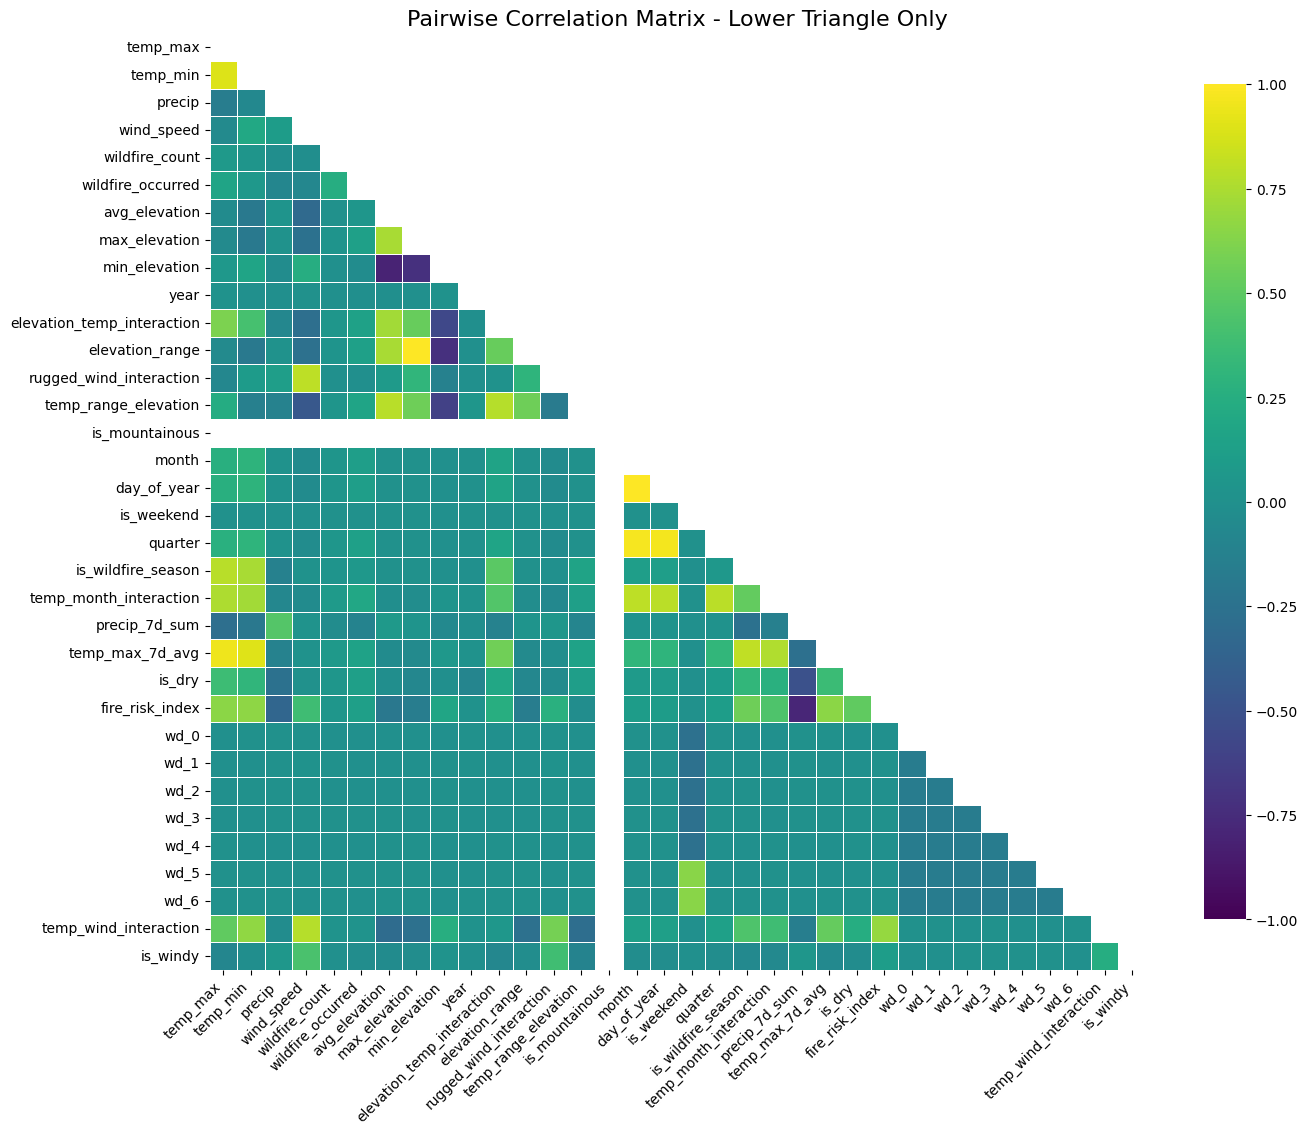

In [86]:
corr_matrix = df_features.select_dtypes(include=[np.number]).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='viridis',
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Pairwise Correlation Matrix - Lower Triangle Only', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The pairwise correlation matrix was computed across all numeric features to detect potential multicollinearity and understand feature relationships. While most features showed low to moderate correlation, a few expected relationships (e.g., between temperature variables and elevation) appeared.
No extremely high correlations (close to ±1) were observed that would raise immediate concerns for feature redundancy

This feature engineering process enhances the raw data by introducing targeted geographic, temporal, and weather-based features.  
The final dataset is designed to better capture the real-world drivers of wildfire occurrence. We have created 18 more features from the "static" 18 

# Train/Test Split

## Define target variable and features

We define the target variable as whether a wildfire occurred and build the feature set by dropping columns not needed for modeling. 

In [74]:
target_col = 'wildfire_occurred'


X = df_features.drop(columns=[
    'date', 
    #'wd_0', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6',
    'wildfire_count',  
    target_col
])
y = df_features[target_col]

## Label encoding for regions

Since the 'region' feature is categorical, we encode it into numerical values using label encoding.

In [38]:
label_encoder = LabelEncoder()

# Encode categorical feature 'region'
X['region_encoded'] = label_encoder.fit_transform(df_features['region'])

# Drop original 'region' after encoding
X = X.drop(columns=['region'])

We split the dataset into training and testing sets with stratification to preserve the class balance.  
A fixed random state ensures reproducibility of the results.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
) 

# Baseline Model

## Scaling the features

Because some features have different ranges, we apply standard scaling so that all features are on a similar scale. This is needed because models like Logistic Regression, which are sensitive to feature magnitudes.

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We use a simple Logistic Regression as the first model to set a baseline. Since our wildfire data is imbalanced (many more no-fire days than fire days), we balance the class weights automatically

In [76]:
baseline_model = LogisticRegression(
    class_weight='balanced',   # Important for imbalanced classes
    max_iter=1000,              # Ensure convergence
    random_state=42
)

In [77]:
baseline_model.fit(X_train, y_train)

/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-p

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [78]:
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC/PR curves

/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Thomas/Desktop/Skole/Business Analytics/default_ml/lib/python3.12/site-packages/sklear

After training, we make predictions and evaluate them. We print a classification report, ROC AUC score, and Precision-Recall AUC score. These metrics help us understand how well the model identifies wildfires versus non-wildfires and how it handles imbalanced classes.

In [79]:
print("Classification Report for Baseline Model (Logistic Regression):")
print(classification_report(y_test, y_pred_baseline))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_baseline))
print("Average Precision (PR AUC):", average_precision_score(y_test, y_proba_baseline))

Classification Report for Baseline Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     10671
           1       0.28      0.74      0.40      1804

    accuracy                           0.69     12475
   macro avg       0.61      0.71      0.60     12475
weighted avg       0.84      0.69      0.73     12475

ROC AUC Score: 0.7783621440375214
Average Precision (PR AUC): 0.3805710237854889


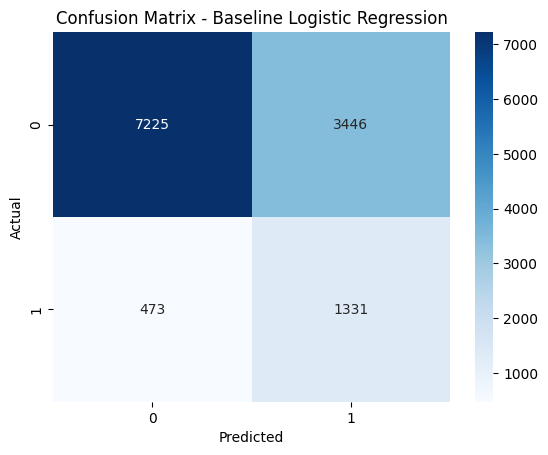

In [45]:
cm = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Baseline Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

This matrix shows how many fires and non-fires were correctly and incorrectly predicted. It helps us assess the balance between false positives and false negatives, which is important for risk management in wildfire prediction

# XGboost Model

## Compute sample weights based on resampled data

### Preparing for imbalanced classification 

### scale_pos_weight

We prepare the data to handle class imbalance by calculating appropriate sample weights. These adjustments are important to prevent the model from being biased toward the majority class (no fire) as we showed early in EDA stage

We used this website to understand and see syntax of how to handle imbalancedment 

https://xgboosting.com/xgboost-for-imbalanced-classification/

In [ ]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Hyperparameter tuning

These site is used in the process to understand and create hyperparameter tuning 

https://xgboosting.com/configure-xgboost-objective-reglogistic-vs-binarylogistic/

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

https://xgboosting.com/xgboost-configure-max_delta_step-parameter-for-imbalanced-classification/


To optimize the XGBoost model, a range of hyperparameters is tested using randomized search and 7-fold cross-validation. This helps us find the best balance between underfitting and overfitting. In the Ensemble learning lecture PP, there was a great focus on cross validation and 7 seem to work the best in this case. Didn't slow it down that much

Randomized Grid Search

Instead of exhaustively searching all combinations, a random subset of parameter settings is tested, making tuning faster while still exploring enough to find a strong model.

In [48]:
# =============================
# Suppress XGBoost Warning
# =============================
warnings.filterwarnings(action='ignore', category=UserWarning, module='xgboost')

# =============================
# Define Hyperparameter Grid and Cross-validation
# =============================
cv_folds = 7  

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# =============================
# Calculate scale_pos_weight for Class Imbalance
# =============================
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# =============================
# Randomized Grid Search for Binary Classification
# =============================
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        max_delta_step=1,
        random_state=42
    ),
    param_distributions=param_grid,
    n_iter=100,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# =============================
# Grid Search for Binary Classification
# =============================
# grid_search = GridSearchCV(
#     estimator=XGBClassifier(
#         objective='binary:logistic',
#         eval_metric='logloss',
#         scale_pos_weight=scale_pos_weight,
#         random_state=42
#     ),
#     param_grid=param_grid,
#     scoring='f1',
#     cv=cv,
#     verbose=1,
#     n_jobs=-1
# )

# =============================
    # Fit Model with Balanced Sample Weights
# =============================
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

random_search.fit(X_train, y_train, sample_weight=sample_weights)
# grid_search.fit(X_train, y_train, sample_weight=sample_weights)  # 

# =============================
# Extract and Display Best Model Parameters and Performance
# =============================
best_model = random_search.best_estimator_
# best_model = grid_search.best_estimator_  # 

print("Best Parameters Found:")
print(random_search.best_params_)
# print(grid_search.best_params_)  

print("\nBest Cross-Validated F1 Score:")
print(random_search.best_score_)


Fitting 7 folds for each of 100 candidates, totalling 700 fits
Best Parameters Found:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}

Best Cross-Validated F1 Score:
0.49038862261715993


## Train model

Using the best parameters found from hyperparameter tuning, the model is trained with the training data and corresponding sample weights to account for class imbalance.

In [49]:
best_model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=9, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

## Thresh hold tuning and evaluation 

This code block finalizes the wildfire prediction model by applying a custom classification threshold - 0.72 instead of the default 0.5 and also looked into 0.3. The model first outputs a probability score between 0 and 1 for each test observation, representing the estimated likelihood of wildfire occurrence.

 By tuning the threshold based on a precision-recall tradeoff analysis, the classification decision becomes more conservative—i.e., a fire is only predicted when the model is highly confident. This helps reduce false positives - unnecessary alerts, which is crucial in real-world scenarios where over-alerting can waste resources


- If probability ≥ 0.72 → predict 1 (wildfire)
-	Otherwise → predict 0 (no wildfire)

In [ ]:
# Predict probabilities
y_probs = best_model.predict_proba(X_test)[:, 1]

# Adjust classification threshold
y_pred_adjusted = (y_probs >= 0.72).astype(int) # this was adjusted because of the threshold curve that is geting visualized further down. We started with 0.3 

# Evaluate
print("Classification Report - Threshold = 0.72:")
print(classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))

Classification Report - Threshold = 0.72:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     10671
           1       0.46      0.55      0.50      1804

    accuracy                           0.84     12475
   macro avg       0.69      0.72      0.70     12475
weighted avg       0.85      0.84      0.85     12475

Confusion Matrix:
[[9528 1143]
 [ 818  986]]


### Threshold Optimization Curve 

After training, predicted probabilities are generated. Instead of using the default 0.5 threshold, we tune the threshold based on F1-score to better balance precision and recall for the imbalanced dataset

In [51]:

def plot_precision_recall_thresholds(y_true, y_probs, show_f1=True):
    """
    Plots precision, recall, and F1 score against decision thresholds.
    
    Args:
        y_true (array): Ground truth binary labels
        y_probs (array): Predicted probabilities for class 1
        show_f1 (bool): Whether to also plot F1 score
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], label='Precision', linestyle='--')
    plt.plot(thresholds, recalls[:-1], label='Recall', linestyle='-')
    if show_f1:
        plt.plot(thresholds, f1s[:-1], label='F1 Score', linestyle='-.')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall and F1 vs Threshold')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Print the best threshold based on F1
    best_idx = np.argmax(f1s)
    best_threshold = thresholds[best_idx]
    print(f"Best F1 Score = {f1s[best_idx]:.4f} at Threshold = {best_threshold:.2f}")

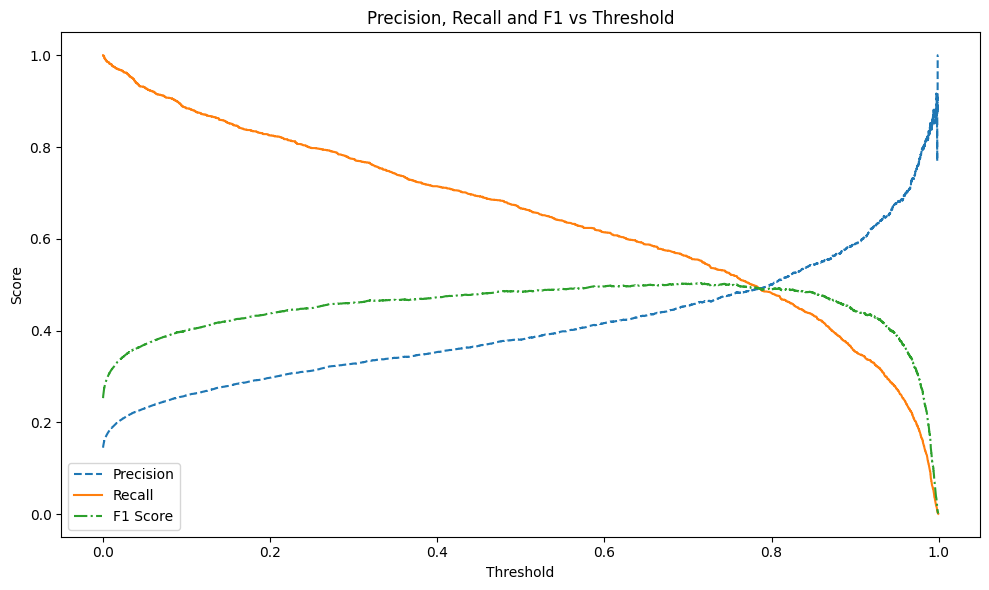

Best F1 Score = 0.5035 at Threshold = 0.72


In [52]:
y_probs = best_model.predict_proba(X_test)[:, 1]  # get probabilities for class 1
plot_precision_recall_thresholds(y_test, y_probs)

## ROC Curve

The Receiver Operating Characteristic (ROC) curve is plotted to evaluate the model’s ability to distinguish between classes at various thresholds. AUC summarizes the model’s discrimination power

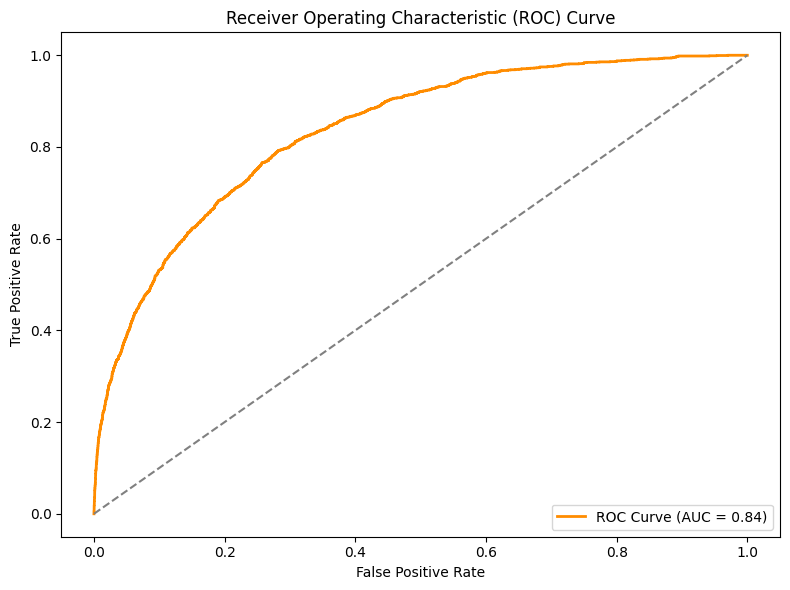

In [55]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="darkorange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(False)
plt.tight_layout()
plt.show()

The ROC curve illustrates the model's ability to distinguish between fire and non-fire events at various thresholds.  
An AUC of **0.84** indicates strong overall discrimination, meaning the model can reliably differentiate between wildfire occurrence and non-occurrence across different probability thresholds.

## PR Curve

The precision-recall curve is plotted to show the trade-off between precision and recall. It is especially useful for evaluating models trained on imbalanced datasets like ours.

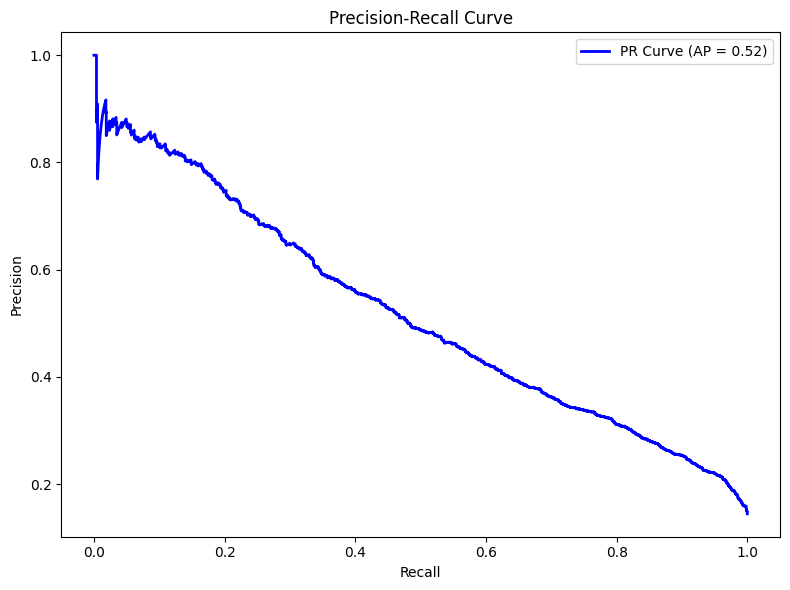

In [56]:

# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})", color="blue", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()
plt.show()

The Precision-Recall curve highlights the model’s ability to balance precision and recall across different thresholds. 
With an average precision (AP) score of 0.52, the model demonstrates moderate ability to correctly identify true wildfire events in an imbalanced dataset, 
where minimizing false positives and capturing actual fires is critical for operational decision-making.

# Model Comparison

### Comparing confusing matrix

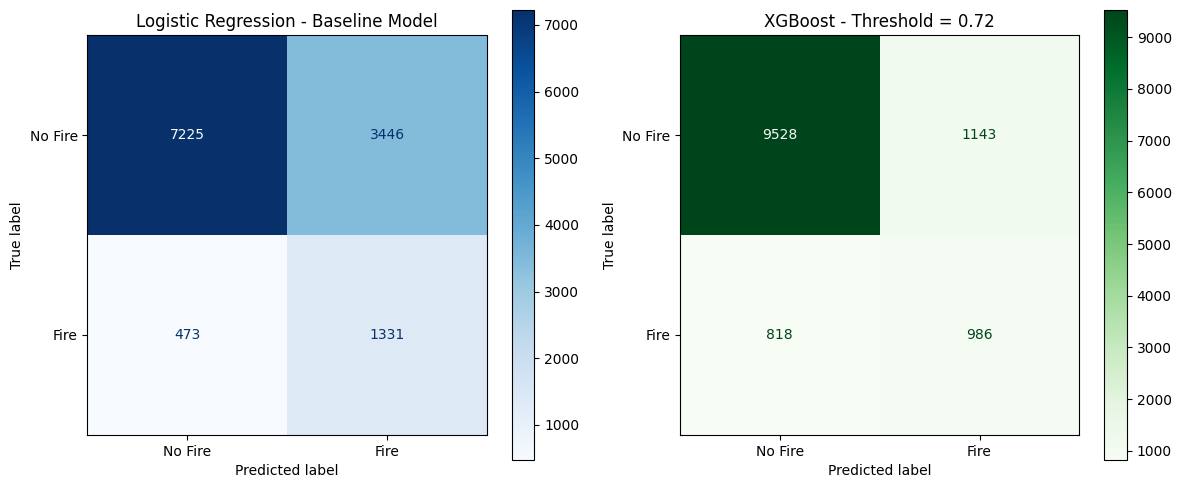

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_baseline,
    display_labels=["No Fire", "Fire"],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Logistic Regression - Baseline Model")

# Final XGBoost
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_adjusted, # 
    display_labels=["No Fire", "Fire"],
    cmap="Greens",
    ax=axes[1]
)
axes[1].set_title("XGBoost - Threshold = 0.72")

plt.tight_layout()
plt.show()

The Logistic Regression baseline model achieved a recall of 74% but with low precision (28%) and an F1 score of 40%.  
XGBoost at the default threshold of 0.3 slightly improved the recall to 73% and the F1 score to 44%, but precision remained similarly low at 31%.

After threshold optimization, setting the XGBoost threshold to 0.72 substantially increased the precision to 46%, while recall slightly decreased to 55%.  
This led to the best F1 score of 50%, and the overall accuracy improved significantly to 84%.

**Interpretation for Wildfire Prediction:**

- A higher precision means that when the model predicts a wildfire, it is more likely to be correct.  
  This reduces the number of unnecessary false alarms, which is critical for resource planning.

- A slightly lower recall (compared to the baseline) means that the model might miss some fires, but the overall trade-off leads to a better balance between **detecting true fires** and **avoiding false positives**.

- The F1 score, which is the harmonic mean of precision and recall, provides a single balanced measure of the model's ability to correctly predict wildfire events while minimizing both false positives and false negatives.  
  A higher F1 score reflects a better trade-off and stronger overall model performance, which is particularly important in imbalanced classification tasks like wildfire prediction.

- In a real-world decision-making context, this balance is valuable:  
  authorities can prioritize resources where fires are most likely, while not overwhelming response teams with false alerts.

Thus, tuning the XGBoost threshold provides a more practical and actionable wildfire prediction model.

| Model | Precision (Fire=1) | Recall (Fire=1) | F1 Score (Fire=1) | Accuracy |
|:------|:-------------------|:---------------|:-----------------|:---------|
| Logistic Regression - Baseline Model | 28% | 74% | 40% | 69% |
| XGBoost - threshold 0.3 | 31% | 73% | 44% | 73% |
| XGBoost - optimized threshold 0.72 | **46%** | **55%** | **50%** | **84%** |

Source used to understand output a little better: 

https://encord.com/blog/f1-score-in-machine-learning/

## Feature importance

we analyzed the importance of the features using the “gain” metric, which measures how much each feature improves the model’s splits

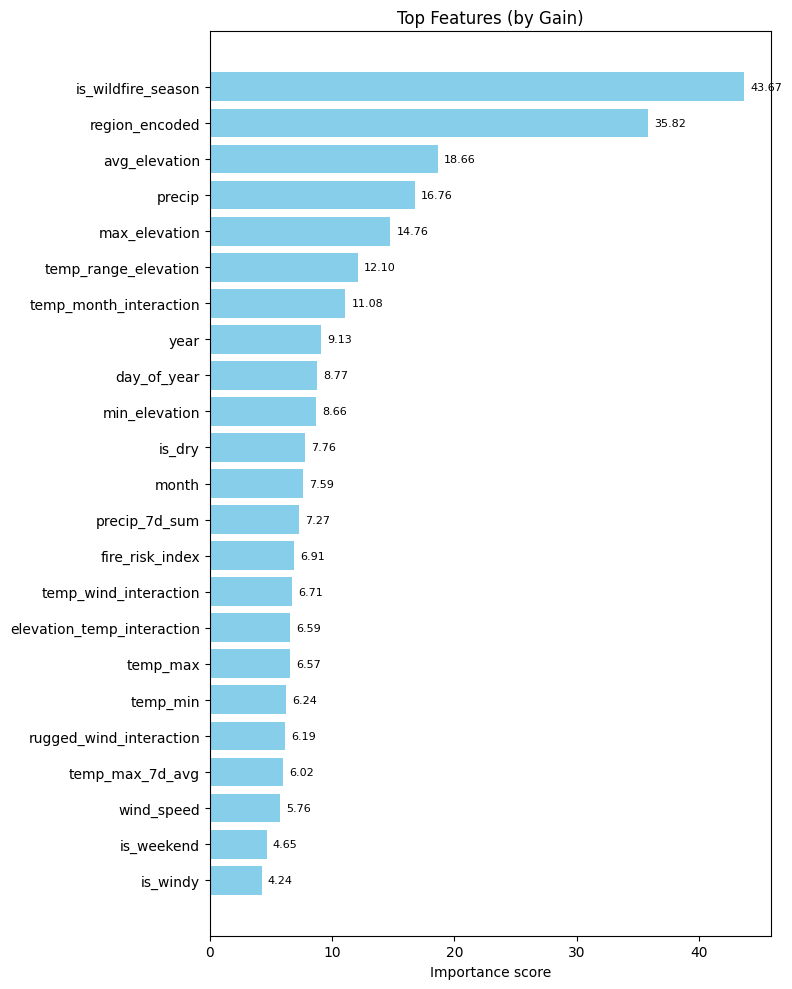

In [59]:
# Extract feature importance manually
importance = best_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

# Plot manually
plt.figure(figsize=(8, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance score')
plt.title('Top Features (by Gain)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.grid(False)

# Annotate bars with importance values (2 decimals)
for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.5, index, f"{value:.2f}", va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()

The most influential factors for predicting wildfire occurrence were whether it is wildfire season, the region itself, and elevation-related features.
Features like recent precipitation, temperature range, and temperature-month interactions also contributed meaningfully to predictions.

The feature “is_wildfire_season” was by far the strongest driver, confirming that wildfires are highly seasonal events in Greece.
Regional differences and elevation factors further suggest that geography and topography significantly influence wildfire risk.

Understanding feature importance helps validate the model’s behavior and guides future decisions, such as where preventive efforts might be prioritized.

### Decode region mappings

In [ ]:
region_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(region_mapping)  

{np.int64(0): 'Aegean', np.int64(1): 'Attica', np.int64(2): 'Crete', np.int64(3): 'EpirusandWesternMacedonia', np.int64(4): 'MacedoniaandThrace', np.int64(5): 'Peloponnese,WesternGreeceand', np.int64(6): 'ThessalyandCentralGreece'}


## SHAP

The SHAP analysis provides insights into which features most influence the wildfire prediction model. Was inspired to be used based on the lecture of explainable AI. Since it could be very interesting to udnerstand the prediction for wildfires in this case

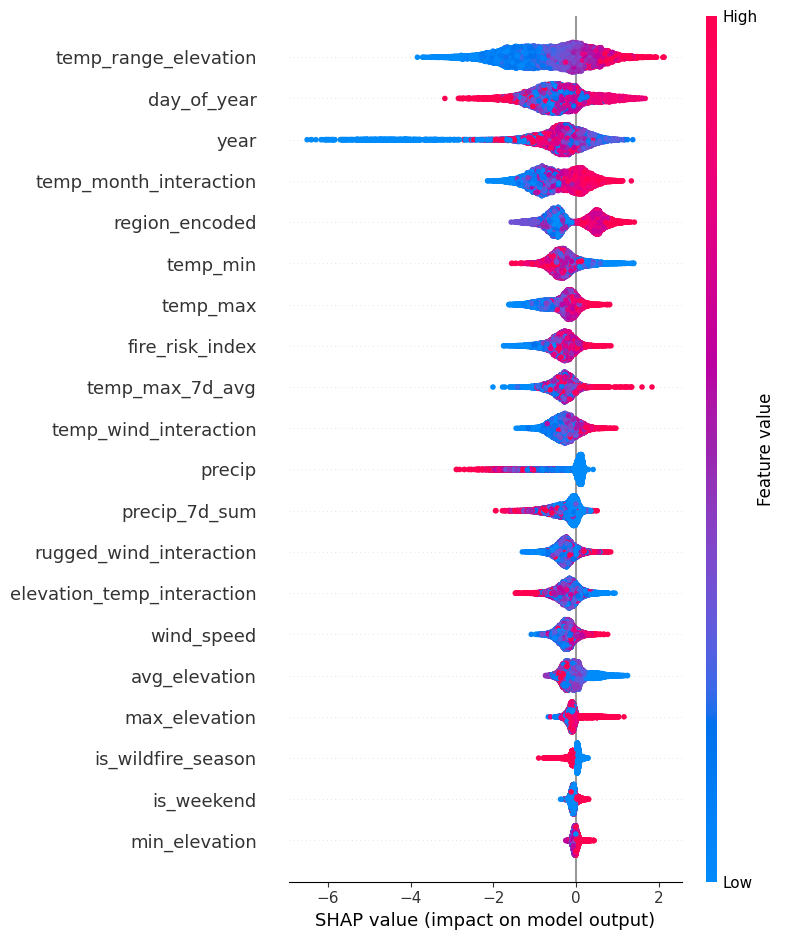

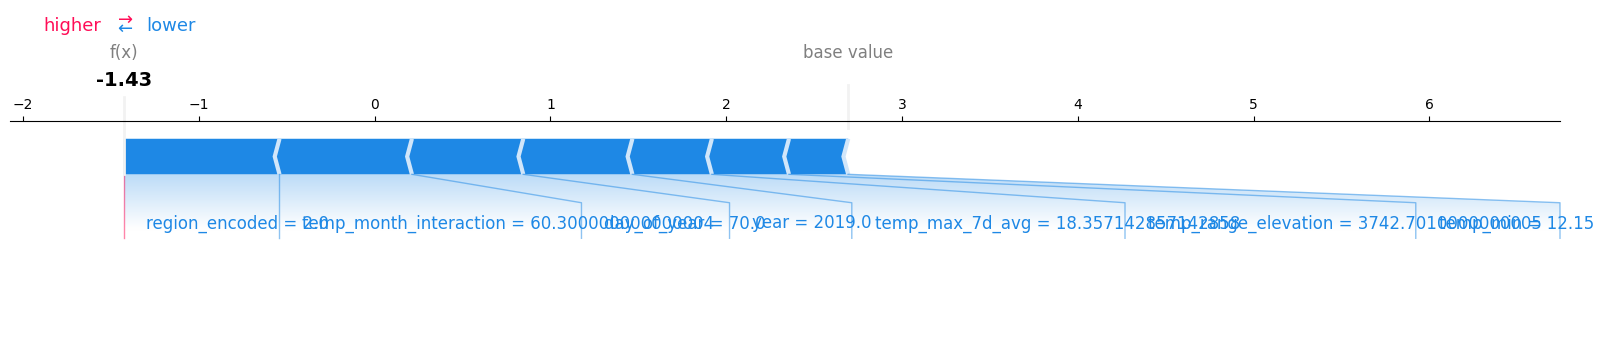

<Figure size 640x480 with 0 Axes>

In [60]:

# =============================
# Create SHAP Explainer
# =============================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# =============================
# Global Summary Plot (Violin-style)
# =============================
# This shows the top features across all samples
shap.summary_plot(shap_values, X_test, max_display=20)

# Optionally save a high-res version
# shap.summary_plot(shap_values, X_test, show=False)
# plt.tight_layout()
# plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
# plt.show()

# =============================
# Local Force Plot (Top-N Feature Version)
# =============================

sample_idx = 0  # sample to explain

# Sort and reduce to top-N most impactful features for readability
top_n = 7
shap_val_sample = shap_values[sample_idx]
top_idx = np.argsort(np.abs(shap_val_sample))[-top_n:]
top_features = X_test.iloc[sample_idx, top_idx]
top_shap_values = shap_val_sample[top_idx]

# Static force plot (matplotlib readable)
shap.initjs()  # Only needed for interactive JS plot (optional in notebook)
shap.force_plot(
    explainer.expected_value,
    top_shap_values,
    top_features,
    matplotlib=True
)

plt.tight_layout()
plt.savefig("shap_force_plot.png", dpi=300, bbox_inches='tight')
plt.show()

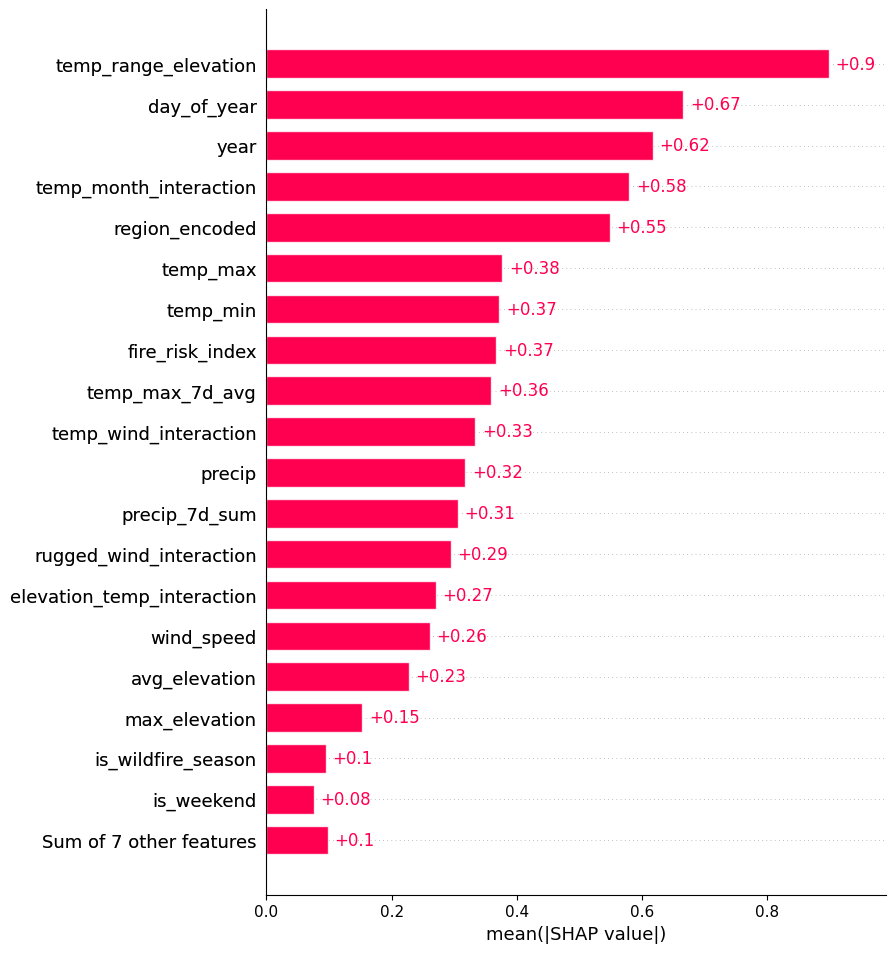

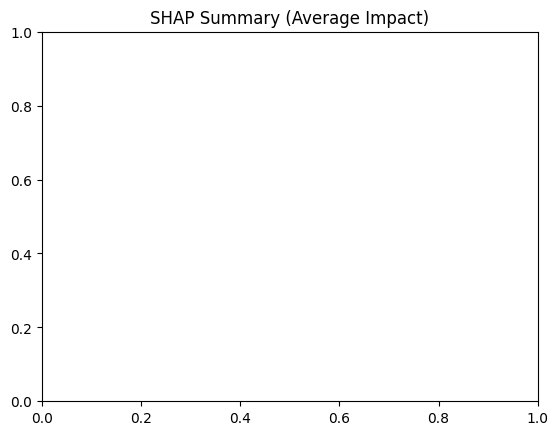

In [61]:

# 1. Create the explainer
explainer = shap.TreeExplainer(best_model)

# 2. Calculate SHAP values
shap_values = explainer.shap_values(X_train)

# 3. Create an Explanation object manually
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_train,
    feature_names=X_train.columns
)

# 4. Now plot
shap.plots.bar(shap_explanation, max_display=20)
plt.title("SHAP Summary (Average Impact)")
plt.show()

While the traditional feature importance plot highlights which variables contribute most to the model’s predictive performance (e.g., is_wildfire_season and region_encoded), SHAP values provide a much richer interpretation of how individual feature values influence the model’s output for wildfire prediction. SHAP not only ranks features by importance but also shows the direction and magnitude of their effect—whether increasing or decreasing the probability of a wildfire for a given sample.

From the SHAP summary, we observe that temp_range_elevation has the highest average impact, suggesting that large temperature swings in elevated areas are a strong signal of fire risk—likely due to drying effects and fuel volatility. The day_of_year and year features also play key roles, reflecting seasonal trends and long-term climate shifts. temp_month_interaction and fire_risk_index further emphasize how compound effects between temperature and time contribute meaningfully to fire likelihood.


While feature importance by gain gives a general idea of which features the model uses most, SHAP values provide a more detailed and consistent explanation of how each feature affects individual wildfire predictions. Therefore, SHAP gives a deeper and more trustworthy understanding for interpreting the wildfire model behavior. 


Source: 

https://datascientistsdiary.com/shap-values-vs-feature-importance/

# Conclusion

The optimized XGBoost model improved wildfire prediction performance compared to the baseline Logistic Regression model. Precision increased from 28% to 46%, F1 score improved from 40% to 50%, and overall accuracy rose from 69% to 84%, offering a practical tool for early wildfire risk identification.

SHAP analysis revealed that variables such as temp_range_elevation, day_of_year, and year had the strongest influence on the model’s predictions, helping to make the model’s behavior more interpretable and aligned with seasonal and geographic wildfire patterns.

A critical aspect of model calibration involved adjusting the classification threshold used to convert predicted probabilities into binary alerts. While a lower threshold (e.g., 0.3) increased sensitivity and caught more true wildfires, it also produced more false positives—cases where a fire was predicted but did not occur. By increasing the threshold to 0.72, the model achieved better precision and a more balanced F1 score, which is particularly useful in resource-constrained environments such as limit on firefighters, trucks ect.

However, it is worth noting that false positives in wildfire prediction are not necessarily a drawback. In many real-world scenarios, a cautious alert—where a fire is predicted but does not occur—may still be beneficial, allowing authorities to increase readiness or issue warnings that prevent human-caused ignition. This makes the model especially valuable in a prevention context, where the cost of acting on a false alarm is often far lower than the cost of missing an actual fire event.

By balancing these trade-offs, the final model not only improves technical performance metrics but also aligns well with practical objectives in wildfire prevention and emergency planning.